Initial tests

In [1]:
import pandas as pd
import transformers
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import torch.nn.functional as F

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# mount drive to save stuff
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# will check and use MPS if available, otherwise CUDA, otherwise CPU
# mps is super fast mac thing
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA (GPU) - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Using device: MPS (Apple)


In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
# For downloading entire datasets, install the kaggle API client:
!pip install kaggle

import kagglehub
from kagglehub import KaggleDatasetAdapter

# --------- Run once ---------
# 1. Go to your Kaggle profile: https://www.kaggle.com/<your-username>/account
# 2. Under 'API', click 'Create New API Token' to download `kaggle.json`.
# 3. Upload `kaggle.json` to your Colab environment (e.g., File -> Upload to session storage).
# 4. Run the following commands in a separate cell or uncomment and run them here:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# -----------------------------------------------------

import kaggle

# Download the entire dataset to a local directory and unzip it
dataset_name = "ashery/chexpert"
download_path = "./CheXpert-v1.0-small"
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)

print(f"Dataset '{dataset_name}' downloaded to: {download_path}")
print("Files in the downloaded dataset:")
!ls -F {download_path}

Dataset URL: https://www.kaggle.com/datasets/ashery/chexpert
Dataset 'ashery/chexpert' downloaded to: ./CheXpert-v1.0-small
Files in the downloaded dataset:
train/	train.csv  valid/  valid.csv


In [5]:
# Load in data and then use only 25% for training and validation
train_full = pd.read_csv("CheXpert-v1.0-small/train.csv")
val_full = pd.read_csv("CheXpert-v1.0-small/valid.csv")
train_subset = train_full.sample(frac=0.25, random_state=42)
val_subset = val_full.sample(frac=0.25, random_state=42)

In [6]:
train_full.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'],
      dtype='object')

In [7]:
train_full = train_full.fillna(0)
val_full = val_full.fillna(0)

Encoder Classes

### Text Encoder

In [8]:
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"

In [9]:
class ClinicalTextEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super(ClinicalTextEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.proj = nn.Linear(768, embed_dim)

    def forward(self, token_ids, attention_masks):
        outputs = self.bert(token_ids, attention_mask=attention_masks)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings = self.proj(cls_embeddings)
        # normalizing because we need to compare with image embeddings later
        # for the contrastive similarity
        embeddings = F.normalize(embeddings, p=2, dim=-1, eps=1e-6)
        return embeddings

### GAN

In [10]:
def generate_report_updated(row):
    labels = row.iloc[5:]  # Skip Path, Sex, Age, Frontal/Lateral, AP/PA

    # Separate findings by certainty
    positive_findings = list(labels[labels == 1.0].index)
    uncertain_findings = list(labels[labels == -1.0].index)

    # Build the report
    report_parts = []

    # Add patient demographics for context
    age = int(row["Age"]) if pd.notna(row["Age"]) else None
    sex = row["Sex"].lower() if pd.notna(row["Sex"]) else None
    view = row["Frontal/Lateral"].lower() if pd.notna(row["Frontal/Lateral"]) else None

    # Start with view type
    if view:
        report_parts.append(f"{view.capitalize()} chest radiograph")
    else:
        report_parts.append("Chest radiograph")

    # Add demographics
    demo = []
    if age:
        demo.append(f"{age}-year-old")
    if sex:
        demo.append(sex)
    if demo:
        report_parts.append(f"of {' '.join(demo)} patient")

    # Add findings
    if len(positive_findings) == 0 and len(uncertain_findings) == 0:
        report_parts.append("demonstrates no acute cardiopulmonary abnormality")
    else:
        findings_text = []

        # Definite findings
        if positive_findings:
            findings_clean = [f.lower().replace("_", " ") for f in positive_findings]
            findings_text.append("shows " + ", ".join(findings_clean))

        # Uncertain findings (optional - you might want to treat these differently)
        if uncertain_findings:
            uncertain_clean = [f.lower().replace("_", " ") for f in uncertain_findings]
            findings_text.append("possible " + ", ".join(uncertain_clean))

        report_parts.append(". ".join(findings_text))

    return " ".join(report_parts) + "."

In [11]:
# new dataset for image size


class CustomGANDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        df = df.reset_index(drop=True)  # Reset index to ensure 0-based indexing
        # Text stuff
        self.text_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.reports = df.apply(
            generate_report_updated, axis=1
        )  # Maybe move generate report to inside the dataset idk

        # Vision stuff?
        self.images = df["Path"]
        self.transform = transforms.Compose(
            [
                transforms.Resize((128, 128)),  # changed from 256 to 128
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5],
                ),  # maps [0,1] -> [-1,1]
            ]
        )

    def __len__(self):
        return len(self.reports)  # This could work or we could do another way

    def __getitem__(self, idx):
        # Text part
        report = self.reports[idx]
        encoder = self.text_tokenizer.encode_plus(
            report,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Vision part
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(image)

        return {
            "token_ids": encoder["input_ids"],
            "attention_masks": encoder["attention_mask"],
            "image_tensor": img_tensor,
        }  # Is vision part correct?

In [12]:
# Create train & val datasets
train_gandataset = CustomGANDataset(train_full)
val_gandataset = CustomGANDataset(val_full)

/Users/kaylahaeusssler/miniforge3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Create data loaders
train_ganloader = DataLoader(train_gandataset, batch_size=32, shuffle=True)
val_ganloader = DataLoader(val_gandataset, batch_size=32, shuffle=False)

In [15]:
text_enc = ClinicalTextEncoder(embed_dim=512).to(device)

# Load the best weights
best_path = "checkpoint_iter_14000.pt"
state = torch.load(best_path, map_location=device)
text_enc.load_state_dict(state["text_enc"])

<All keys matched successfully>

In [16]:
# freezing text encoder

text_enc.eval()
for p in text_enc.parameters():
    p.requires_grad = False

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, t_dim=512):
        super().__init__()
        in_dim = z_dim + t_dim  # 640

        # start from 8x8
        self.fc = nn.Linear(in_dim, 512 * 8 * 8)

        self.main = nn.Sequential(
            # 512 x 8 x 8 -> 256 x 16 x 16
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 16 x 16 -> 128 x 32 x 32
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 32 -> 64 x 64 x 64
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 64 -> 3 x 128 x 128
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),  # output in [-1, 1]
        )

    def forward(self, z_noise, e_text):
        cond = torch.cat([z_noise, e_text], dim=-1)  # [B, 640]
        x = self.fc(cond)  # [B, 512*8*8]
        x = x.view(x.size(0), 512, 8, 8)  # [B, 512, 8, 8]
        img = self.main(x)  # [B, 3, 128, 128]
        return img

In [18]:
class Discriminator(nn.Module):
    def __init__(self, t_dim=512):
        super().__init__()
        self.img_net = nn.Sequential(
            # 3 x 128 x 128 -> 64 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 64 x 64 -> 128 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 32 x 32 -> 256 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 16 x 16 -> 512 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # final feature map: [B, 512, 8, 8]
        self.fc_img = nn.Linear(512 * 8 * 8, 512)
        self.fc_joint = nn.Linear(512 + t_dim, 1)

    def forward(self, img, e_text):
        feat = self.img_net(img)  # [B, 512, 8, 8]
        feat = feat.view(feat.size(0), -1)  # [B, 512*8*8]
        feat = self.fc_img(feat)  # [B, 512]
        joint = torch.cat([feat, e_text], dim=-1)  # [B, 512 + t_dim]
        out = self.fc_joint(joint)  # [B, 1]
        return out

In [18]:
# Initialize generator and discriminator
generator = Generator(z_dim=128, t_dim=512).to(device)
discriminator = Discriminator(t_dim=512).to(device)
adversarial_loss = torch.nn.BCELoss()

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [ ]:
num_epochs = 10
print_every = 2000
checkpoint_every = 5000

iteration = 0
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    running_loss_G = []
    running_loss_D = []
    for batch in train_ganloader:
        real_imgs = batch["image_tensor"].to(device)  # [B,3,256,256]
        token_ids = batch["token_ids"].squeeze(1).to(device)
        attention_masks = batch["attention_masks"].squeeze(1).to(device)
        B = real_imgs.size(0)

        with torch.no_grad():
            e_text = text_enc(token_ids, attention_masks)  # [B,512]
        # !! generating random embeddings to test since encoder not trained yet
        # e_text = torch.randn(B, 512, device=device)

        z = torch.randn(B, 128, device=device)

        # --------------------
        # Train Discriminator
        # --------------------
        fake_imgs = generator(z, e_text).detach()
        real_logits = discriminator(real_imgs, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_D = 0.5 * (
            F.binary_cross_entropy_with_logits(
                real_logits, torch.ones_like(real_logits)
            )
            + F.binary_cross_entropy_with_logits(
                fake_logits, torch.zeros_like(fake_logits)
            )
        )

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --------------------
        # Train Generator
        # --------------------
        z = torch.randn(B, 128, device=device)
        fake_imgs = generator(z, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_G = F.binary_cross_entropy_with_logits(
            fake_logits, torch.ones_like(fake_logits)
        )

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        # Track losses
        running_loss_G.append(loss_G.item())
        running_loss_D.append(loss_D.item())

        # Print progress
        if iteration % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Iteration {iteration}")
            print(f"  Loss_D: {loss_D.item()}")
            print(f"  Loss_G: {loss_G.item()}")
            print(f"  Avg Loss_D: {np.mean(running_loss_D)}")
            print(f"  Avg Loss_G: {np.mean(running_loss_G)}")

        if iteration % checkpoint_every == 0 and iteration > 0:
            ckpt = {
                "epoch": epoch,
                "iteration": iteration,
                "G_state_dict": generator.state_dict(),
                "D_state_dict": discriminator.state_dict(),
                "opt_G_state_dict": opt_G.state_dict(),
                "opt_D_state_dict": opt_D.state_dict(),
            }
            torch.save(
                ckpt,
                f"/content/drive/MyDrive/CXR_GAN_Models/10epochs_gan_{iteration}.pt",
            )
            print(f"Saved checkpoint at iter {iteration}")
        iteration += 1

    print(
        f"Epoch {epoch+1} finished | Avg_D: {np.mean(running_loss_D):.4f}, Avg_G: {np.mean(running_loss_G):.4f}"
    )

Epoch [1/10] Iteration 0
  Loss_D: 0.7247560024261475
  Loss_G: 1.7619481086730957
  Avg Loss_D: 0.7247560024261475
  Avg Loss_G: 1.7619481086730957
Epoch [1/10] Iteration 2000
  Loss_D: 0.4970790147781372
  Loss_G: 1.4758760929107666
  Avg Loss_D: 0.4829558743045745
  Avg Loss_G: 3.0017519420201797
Epoch [1/10] Iteration 4000
  Loss_D: 0.5593823194503784
  Loss_G: 0.5045589208602905
  Avg Loss_D: 0.46895484896867984
  Avg Loss_G: 2.673067259342242
Saved checkpoint at iter 5000
Epoch [1/10] Iteration 6000
  Loss_D: 0.2947351336479187
  Loss_G: 2.6429920196533203
  Avg Loss_D: 0.44905891255540054
  Avg Loss_G: 2.6592751493963984
Epoch 1 finished | Avg_D: 0.4408, Avg_G: 2.6642
Epoch [2/10] Iteration 8000
  Loss_D: 0.5364586710929871
  Loss_G: 2.386693000793457
  Avg Loss_D: 0.36998588391474585
  Avg Loss_G: 2.8214500971993943
Epoch [2/10] Iteration 10000
  Loss_D: 0.2375544011592865
  Loss_G: 2.4090638160705566
  Avg Loss_D: 0.3526887334574726
  Avg Loss_G: 2.9381724845676005
Saved check

In [ ]:
import os

save_dir = "/content/drive/MyDrive/CXR_GAN_Models"
os.makedirs(save_dir, exist_ok=True)

print("Saving to:", save_dir)

In [ ]:
G_path = os.path.join(save_dir, "10epoch_clinical_generator.pt")
D_path = os.path.join(save_dir, "10epoch_clinical_discriminator.pt")

torch.save(generator.state_dict(), G_path)
torch.save(discriminator.state_dict(), D_path)

print("Models saved to Google Drive.")

In [20]:
best_chckpt = torch.load("10epochs_gan_500000.pt", map_location=device)

FileNotFoundError: [Errno 2] No such file or directory: '10epochs_gan_500000.pt'

In [ ]:
print("checkpoint keys:", best_chckpt.keys())

In [19]:
# Recreate your model classes
G = Generator(z_dim=128, t_dim=512).to(device)
D = Discriminator(t_dim=512).to(device)

# Load saved weights
G.load_state_dict(torch.load(G_path, map_location=device))
D.load_state_dict(torch.load(D_path, map_location=device))

G.eval()
D.eval()
print("Models loaded!")

NameError: name 'G_path' is not defined

In [23]:
generator = Generator(z_dim=128, t_dim=512).to(device)
discriminator = Discriminator(t_dim=512).to(device)

opt_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

ckpt_path = "10epochs_gan_50000.pt"
ckpt = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(ckpt["G_state_dict"])
discriminator.load_state_dict(ckpt["D_state_dict"])

<All keys matched successfully>

In [24]:
opt_G.load_state_dict(ckpt["opt_G_state_dict"])
opt_D.load_state_dict(ckpt["opt_D_state_dict"])
start_epoch = ckpt["epoch"]
start_iteration = ckpt["iteration"]

In [27]:
# continue training

print_every = 2000
checkpoint_every = 5000
num_epochs = 10
iteration = start_iteration
for epoch in range(start_epoch, num_epochs):
    generator.train()
    discriminator.train()
    running_loss_G = []
    running_loss_D = []
    for batch in train_ganloader:
        real_imgs = batch["image_tensor"].to(device)  # [B,3,256,256]
        token_ids = batch["token_ids"].squeeze(1).to(device)
        attention_masks = batch["attention_masks"].squeeze(1).to(device)
        B = real_imgs.size(0)

        with torch.no_grad():
            e_text = text_enc(token_ids, attention_masks)  # [B,512]
        # !! generating random embeddings to test since encoder not trained yet
        # e_text = torch.randn(B, 512, device=device)

        z = torch.randn(B, 128, device=device)

        # --------------------
        # Train Discriminator
        # --------------------
        if iteration % 3 == 0:  # Try 2 or 3
            fake_imgs = generator(z, e_text).detach()
            real_logits = discriminator(real_imgs, e_text)
            fake_logits = discriminator(fake_imgs, e_text)
            loss_D = 0.5 * (
                F.binary_cross_entropy_with_logits(
                    real_logits, torch.ones_like(real_logits)
                )
                + F.binary_cross_entropy_with_logits(
                    fake_logits, torch.zeros_like(fake_logits)
                )
            )
            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()
            running_loss_D.append(loss_D.item())

        # --------------------
        # Train Generator
        # --------------------
        z = torch.randn(B, 128, device=device)
        fake_imgs = generator(z, e_text)
        fake_logits = discriminator(fake_imgs, e_text)

        loss_G = F.binary_cross_entropy_with_logits(
            fake_logits, torch.ones_like(fake_logits)
        )

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        # Track losses
        running_loss_G.append(loss_G.item())

        # Print progress
        if iteration % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Iteration {iteration}")
            if len(running_loss_D) > 0:  # Only print if we have D losses
                print(f"  Loss_D: {loss_D.item() if iteration % 3 == 0 else 'N/A'}")
                print(f"  Avg Loss_D: {np.mean(running_loss_D):.4f}")
            print(f"  Loss_G: {loss_G.item()}")
            print(f"  Avg Loss_G: {np.mean(running_loss_G)}")

        if iteration % checkpoint_every == 0 and iteration > 0:
            ckpt = {
                "epoch": epoch,
                "iteration": iteration,
                "G_state_dict": generator.state_dict(),
                "D_state_dict": discriminator.state_dict(),
                "opt_G_state_dict": opt_G.state_dict(),
                "opt_D_state_dict": opt_D.state_dict(),
            }
            torch.save(ckpt, f"CXR_GAN_Models/10epochs_gan_{iteration}.pt")
            print(f"Saved checkpoint at iter {iteration}")
        iteration += 1

    print(
        f"Epoch {epoch+1} finished | Avg_D: {np.mean(running_loss_D):.4f}, Avg_G: {np.mean(running_loss_G):.4f}"
    )

Epoch [7/10] Iteration 50000
  Loss_G: 2.8598484992980957
  Avg Loss_G: 2.8598484992980957
Saved checkpoint at iter 50000
Epoch [7/10] Iteration 52000
  Loss_D: N/A
  Avg Loss_D: 0.3302
  Loss_G: 2.6754605770111084
  Avg Loss_G: 3.1979587695290004
Epoch [7/10] Iteration 54000
  Loss_D: 0.30084002017974854
  Avg Loss_D: 0.3568
  Loss_G: 3.3941173553466797
  Avg Loss_G: 2.8681885363891166
Saved checkpoint at iter 55000
Epoch [7/10] Iteration 56000
  Loss_D: N/A
  Avg Loss_D: 0.3743
  Loss_G: 2.5378496646881104
  Avg Loss_G: 2.711822526020083
Epoch 7 finished | Avg_D: 0.3804, Avg_G: 2.6591
Epoch [8/10] Iteration 58000
  Loss_D: N/A
  Avg Loss_D: 0.4317
  Loss_G: 3.1510791778564453
  Avg Loss_G: 2.314235977923554
Epoch [8/10] Iteration 60000
  Loss_D: 0.752964198589325
  Avg Loss_D: 0.4416
  Loss_G: 2.9573535919189453
  Avg Loss_G: 2.255831531304206
Saved checkpoint at iter 60000
Epoch [8/10] Iteration 62000
  Loss_D: N/A
  Avg Loss_D: 0.4464
  Loss_G: 1.1221098899841309
  Avg Loss_G: 2.22

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

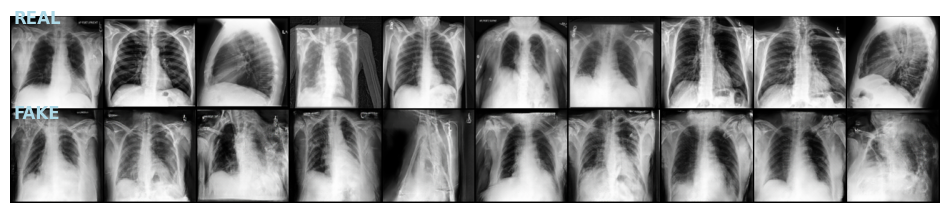

In [21]:
generator.eval()
text_enc.eval()

batch = next(iter(val_ganloader))

# Move to device
real_imgs = batch["image_tensor"].to(device)  # [B, 3, 128, 128]
token_ids = batch["token_ids"].squeeze(1).to(device)  # [B, 512]
attention_masks = batch["attention_masks"].squeeze(1).to(device)

# use the first N samples from this batch
N = 10
real_imgs = real_imgs[:N]
token_ids = token_ids[:N]
attention_masks = attention_masks[:N]

with torch.no_grad():
    # 1) Get text embeddings from your trained text encoder
    e_text = text_enc(token_ids, attention_masks)  # [N, 512]

    # 2) Sample noise with matching batch size
    z = torch.randn(N, 128, device=device)  # [N, 128]

    # 3) Generate fake images conditioned on text
    samples = generator(z, e_text)  # [-1, 1], [N, 3, 128, 128]

    # 4) Undo tanh normalization: [-1,1] -> [0,1]
    samples = (samples + 1) / 2
    real_imgs = (real_imgs + 1) / 2
    both = torch.cat(
        [real_imgs, samples], dim=0
    )  # real_imgs must also be in [0,1] to display nicely
grid = make_grid(both, nrow=N)
plt.figure(figsize=(12, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# Add labels
plt.text(5, 10, "REAL", color="lightblue", fontsize=12, weight="bold")
plt.text(5, 10 + 128 + 5, "FAKE", color="lightblue", fontsize=12, weight="bold")
plt.axis("off")
plt.show()

#### FID

In [22]:
from torchvision.models import inception_v3, Inception_V3_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained InceptionV3 for FID
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights, transform_input=False, aux_logits=True)
inception.fc = nn.Identity()  # so output is 2048-d features, not logits
inception.eval().to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 227MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)


def get_inception_acts(imgs):
    """
    imgs: [B, 3, H, W] in [-1,1]
    returns: [B, 2048] activations
    """
    # [-1,1] -> [0,1]
    imgs = (imgs + 1) / 2

    # Resize to 299x299
    imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)

    # Normalize to ImageNet stats
    imgs = (imgs - IMAGENET_MEAN) / IMAGENET_STD

    with torch.no_grad():
        acts = inception(imgs)  # [B, 2048]
    return acts

In [24]:
# get 1000 real images
def get_acts_real(real_loader, n_samples=10000):
    acts = []
    count = 0
    for batch in real_loader:
        imgs = batch["image_tensor"].to(device)  # [-1,1], [B,3,128,128]
        a = get_inception_acts(imgs)
        acts.append(a.cpu().numpy())
        count += a.size(0)
        if count >= n_samples:
            break
    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]

In [25]:
# generate 1000 fake images
def get_acts_fake(
    G,
    text_enc,
    loader,  # e.g. real_test_loader or train_ganloader
    n_samples=1000,
    z_dim=128,
    device="cuda",
):
    acts = []
    count = 0

    G.eval()
    text_enc.eval()

    with torch.no_grad():
        for batch in loader:
            # 1) get text embeddings for this batch
            token_ids = batch["token_ids"].squeeze(1).to(device)
            attention_masks = batch["attention_masks"].squeeze(1).to(device)

            e_text = text_enc(token_ids, attention_masks)  # [B, 512]
            B = e_text.size(0)

            # maybe we only need part of this batch if we're near n_samples
            curr_bs = min(B, n_samples - count)
            e_text = e_text[:curr_bs]

            # 2) sample noise
            z = torch.randn(curr_bs, z_dim, device=device)

            # 3) generate fake images conditioned on *real* text embeddings
            fake_imgs = G(z, e_text)  # [-1, 1]

            # 4) get Inception activations
            a = get_inception_acts(fake_imgs)  # [curr_bs, 2048]
            acts.append(a.cpu().numpy())

            count += curr_bs
            if count >= n_samples:
                break

    acts = np.concatenate(acts, axis=0)
    return acts[:n_samples]

In [26]:
from scipy import linalg


# get mean and sd
def compute_mu_sigma(acts):
    mu = np.mean(acts, axis=0)
    sigma = np.cov(acts, rowvar=False)
    return mu, sigma


# calculate fid
def fid_from_acts(acts_r, acts_f):
    mu_r, sig_r = compute_mu_sigma(acts_r)
    mu_f, sig_f = compute_mu_sigma(acts_f)

    diff = mu_r - mu_f
    covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)

    # numerical issues: imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sig_r + sig_f - 2 * covmean)
    return float(fid)

In [28]:
# use 1000 real and 1000 fake images
n_samples = 50000
# get images
acts_real = get_acts_real(val_ganloader, n_samples=n_samples)
acts_fake = get_acts_fake(generator, text_enc, val_ganloader, n_samples=n_samples)

# calculate fid between
fid_score = fid_from_acts(acts_real, acts_fake)
print("FID:", fid_score)

/tmp/ipython-input-1897880018.py:14: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sig_r.dot(sig_f), disp=False)


FID: 97.73860706667568
